In [1]:
import numpy as np
import pandas as pd #pip3 install pandas
import matplotlib.pyplot as plt

from cam_to_trajectory import get_index_finger_pose
from cam_to_trajectory import plot_positions
from cam_to_trajectory import get_all_link_poses

In [63]:
def get_link_lengths(keypoint_poses):
    """ keypoint_poses is a dictionary of 5 keys, each with a list of associated poses;
        each associated pose in the list is a triple: (x position, y position)
        
        poses = {
            'neck': [(x,y), ...],          # <=> theta_4
            'shoulder': [(x,y), ...],      # <=> theta_3
            'elbow': [(x,y), ...],         # <=> theta_2
            'wrist': [(x,y), ...],         # <=> theta_1
            'finger': [(x,y), ...]         # <=> 
        }
    
        e.g.,
        the first entry for link 'neck':
        
        keypoint_poses['neck'][0] ==> (265.403, 257.642)
    
    """
    ### create imaginary links b1, b2
    # get first pose of neck keypoint
    theta_4 = keypoint_poses['neck'][0]
    # then draw a straight line below it (-100 pixels) and to the left (-100 pixels)
    # to represent base link b1
    theta_b1 = np.array((theta_4[0] - 200, theta_4[1] - 100))
    # b1 is now defined by endpoints theta_4 and theta_b1
    
    #for be, draw a straight line below it (-100 pixels) and to the right (+100 pixels)
    theta_b2 = np.array((theta_b1[0] + 200, theta_b1[1] - 100))
    # b2 is now defined by endpoints theta_b1 and theta_b2
    
    initial_neck = keypoint_poses['neck'][0]
    initial_shoulder = keypoint_poses['shoulder'][0]
    initial_elbow = keypoint_poses['elbow'][0]
    initial_wrist = keypoint_poses['wrist'][0]
    initial_finger = keypoint_poses['finger'][0]
    b1_len = np.linalg.norm(theta_b1 - initial_neck)
    b2_len = np.linalg.norm(theta_b1 - theta_b2)
    #print("keypoint_poses",theta_b2,theta_b1,initial_neck,initial_shoulder,initial_elbow,initial_wrist,initial_finger)
    
    neck_shoulder = np.linalg.norm(initial_neck - initial_shoulder) 
    shoulder_elbow = np.linalg.norm(initial_shoulder - initial_elbow)
    elbow_wrist = np.linalg.norm(initial_elbow - initial_wrist)
    wrist_finger = np.linalg.norm(initial_wrist - initial_finger)
    L_list=[b1_len, b2_len, neck_shoulder, shoulder_elbow, elbow_wrist, wrist_finger]
    fixed_home_joint_pose=theta_b2
    return L_list , fixed_home_joint_pose

#################
#This function extracts thetas  for each link (joint rotation) based on base cordinate 
#################
def extract_theta_s_list_and_finger_points(keypoint_poses):
    all_theta_s_list=np.empty((0,4))#'4' for the rotary joints
    finger_poses=np.empty((0,2))
    for i in range(len(keypoint_poses['neck'])):
        joints_pose=np.array([keypoint_poses['neck'][i],keypoint_poses['shoulder'][i],keypoint_poses['elbow'][i],
                    keypoint_poses['wrist'][i],keypoint_poses['finger'][i]])
        theta_list=[]
        for j in range(len(joints_pose)-1):
            dx=joints_pose[j+1][0]-joints_pose[j][0]
            dy=joints_pose[j+1][1]-joints_pose[j][1]
            theta=np.arctan(dy/dx)
            if dx<0:# to have theta between (-pi,pi)
                if theta<0:
                    theta+=np.pi
                else:
                    theta-=np.pi
            theta_list.append(theta)
        all_theta_s_list=np.append(all_theta_s_list,[np.array(theta_list)],axis=0)
        finger_poses=np.append(finger_poses,[keypoint_poses['finger'][i]],axis=0)
    return all_theta_s_list , finger_poses


########
#This function makes sure that the thetas are always between (-pi,pi)
########
def check_theta(theta):
    while theta>np.pi:
        theta-= 2*np.pi
    while theta<=-np.pi:
        theta+= 2*np.pi
    return theta 

################
#In this function we calculate positions for fixed link and 
# joint rotations( rotated angles with respect to previous link )
################
def real_pose_and_joint_thetas(theta_s_list,L_list,fixed_point,finger_poses):
    
    real_poses=np.empty((0,len(L_list)+1,2))
    all_joint_rotation_angles=np.empty((0,len(L_list)))
    for i in range(len(theta_s_list)):
        end=finger_poses[i]
        poses=[]
        for j in reversed(range(2,len(L_list))):#skip 2 imaginary links
            new=[end[0]-L_list[j]*np.cos(theta_s_list[i][j-2]),end[1]-L_list[j]*np.sin(theta_s_list[i][j-2])]
            #if i ==0: print(new)
            poses.insert(0,new)
            end=new
            
        # now we calculte the imaginary joint's position
        L_prime=np.linalg.norm(np.array(poses[0]) - np.array(fixed_point))# distance betwin first joint to neck
        if (poses[0][0]-fixed_point[0])==0:
            if ((poses[0][1]-fixed_point[1]))>=0:
                theta_prime = 1.57079632
            elif ((poses[0][1]-fixed_point[1]))<0:
                theta_prime = -1.57079632
        else:
            theta_prime=np.arctan((poses[0][1]-fixed_point[1])/(poses[0][0]-fixed_point[0]))#theta corespond to L_prime
        
        if (poses[0][0]-fixed_point[0])<0:# to have theta between (-pi,pi)
            if theta_prime<0:
                theta_prime+=np.pi
            else:
                theta_prime-=np.pi
                     
        L1=L_list[0] 
        L2=L_list[1]
        L3=L_prime
        #print("cos",(L1**2+L3**2-L2**2)/(2*L1*L3) , L1,L3)
        theta=np.arccos((L1**2+L3**2-L2**2)/(2*L1*L3)) #cosign low in triangle
        theta_base=theta_prime + theta # the (+) forces the imaginary point to always be on the left side of L3
        theta_base=check_theta(theta_base)
        imaginary_joint_pose=np.array([fixed_point[0]+L1*np.cos(theta_base),fixed_point[1]+L1*np.sin(theta_base)])
        #if 737<i<745 : 
        #    print("imaginary_joint_pose",imaginary_joint_pose,theta,theta_base)
        
        
        ###### creating the real pose for all joints:
        
        poses.insert(0,imaginary_joint_pose)
        poses.insert(0,fixed_point)
        poses.append(finger_poses[i])
        real_poses=np.append(real_poses,[np.array(poses)],axis=0)
        
        theta2_s = np.arcsin((poses[2][1]-poses[1][1])/L2)
        if (poses[2][1]-poses[1][1]) <  0:
            theta2_s=np.pi -theta2_s
        theta2_s=check_theta(theta2_s)
        
        
        ######creating the joints theta rotations:
        
        new_theta_list = theta_s_list[i] 
        new_theta_list = np.insert(new_theta_list,0,[theta_base,theta2_s])# 'new_theta_list' contains all thetas with respect to base fram
        joint_angles=[]# 'joint_angles' shows the rotation related to each revolute joint
        previous_joint_angle=0
        for k in range(len(new_theta_list)):
            joint_theta=new_theta_list[k]-previous_joint_angle
            joint_theta=check_theta(joint_theta)
            joint_angles.append(joint_theta)
            previous_joint_angle=new_theta_list[k]
            
        all_joint_rotation_angles=np.append(all_joint_rotation_angles,[np.array(joint_angles)],axis=0)
        
        
    return real_poses , all_joint_rotation_angles

################
#Calculate dthetas based on the thetas and dt
#the last dtheta is equal to last-1
################


def calculate_dthetas(thetas,dt):
    dtheta_list=np.empty((0,len(thetas[0])))
    for i in range(len(thetas)-1):
        dthetas=(thetas[i+1]-thetas[i])/dt
        dtheta_list=np.append(dtheta_list,[dthetas],axis=0)
    dtheta_list=np.append(dtheta_list,[dtheta_list[-1]],axis=0)# to make thetas and dthetas the same size
    return dtheta_list
    
###########
##This is the main function that based on the path to the json files, returns real positions, thetas ,dthetas and L_list
###########
def mapping(path,dt=0.1):
    keypoint_poses = get_all_link_poses(path)
    L_list , fixed_home_joint_pose=get_link_lengths(keypoint_poses)
    all_theta_s_list , finger_poses= extract_theta_s_list_and_finger_points(keypoint_poses)
    real_poses , thetas= real_pose_and_joint_thetas(all_theta_s_list,L_list,fixed_home_joint_pose,finger_poses)
    dthetas=calculate_dthetas(thetas,dt=0.1)
    return real_poses , thetas , dthetas , L_list


In [12]:
def position_from_angle(thetas,L_list,base_pose):
    pose=[base_pose]
    x_old=base_pose[0]
    y_old=base_pose[1]
    for i in range(len(thetas)):
        x=L_list[i]*np.cos(thetas[i])
        y=L_list[i]*np.sin(thetas[i])
        x_old+=x
        y_old+=y
        pose=np.append(pose,[[x_old,y_old]],axis=0)
    return pose



In [13]:
print(position_from_angle([0,0,0],[1,1,1],[0,0]))

[[0. 0.]
 [1. 0.]
 [2. 0.]
 [3. 0.]]


In [51]:
r , angles ,dtheta=mapping('c2poc')
print(dtheta)

[[-4.52513343e-02 -6.27978852e-02  2.67153481e-01 -8.44783790e-02
  -2.23269330e-02 -2.70375734e-01]
 [ 3.39403832e-02 -2.60324144e-02  1.83686932e-01 -2.43752681e-01
   4.85951648e-02 -8.86938549e-05]
 [-8.61394286e-02 -1.80085708e-03  8.81671358e-02 -2.54316022e-02
  -1.27310707e-01  1.96764918e-01]
 ...
 [ 9.05359040e-03  1.08749582e-01 -4.63455326e-01  2.95601438e-01
  -2.22371045e-02  2.41126695e-01]
 [-9.68043191e-04  3.69242592e-03 -1.03926687e-02  9.15530377e-03
   1.17972452e-01 -3.14632946e-01]
 [ 2.27531402e-02 -3.64010035e-02  9.27005068e-02 -1.34760030e-01
   5.46752631e-02 -2.81000155e-02]]


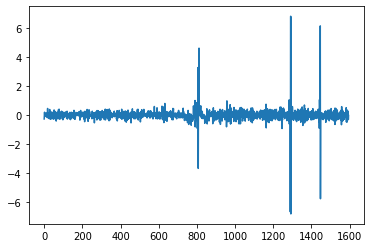

In [61]:
x=dtheta[:,5]
plt.plot(x)

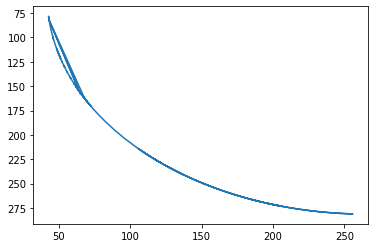

In [52]:
plot_positions(r[:,1])
